# LSTMs (A Brief Introduction)

Long Short Term Memory Networks (LSTM) are recurrent neural networks which incorporates feedback connections hence allowing it to effectively classify time series data where there are relationships between future data and past data.

__The information on Long Short Term Memory Networks was obtained from:__
Saxena S. (30/12/2024), *What is LSTM? Introduction to Long Short-Term Memory*, retrieved on 06/01/2025 from, https://www.analyticsvidhya.com/blog/2021/03/introduction-to-long-short-term-memory-lstm/

The preprocessing steps and the  implementation of the LSTM code is adapted from __Singh A. (14/10/2024), *A Hands-On Introduction to Time Series Classification (with Python Code)*, retrieved on 06/01/2025 from:__ <https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/>

# Import The Relevant Libraries

In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

# Obtain and Process The Vast Data

In [2]:
t_data = pd.read_csv("All_Transient_Data.csv")

In [3]:
# Obtain data for the relevant features
rel_data = t_data[["sbid","beam","name","PSR_Label"]]
rel_data.head()

,sbid,beam,name,PSR_Label
0,49588,beam00,J163259.92-501507.22,1
1,49588,beam00,J163048.20-491129.49,0
2,49588,beam04,J162710.82-481537.04,0
3,49588,beam05,J163250.42-482506.53,0
4,49588,beam06,J164019.07-490047.32,0


In [4]:
# Remove all nan values 
rel_data = rel_data.dropna(how='any',axis=0)

In [5]:
# Obtain the paths for the light curves
rel_data["sbid"] = rel_data["sbid"].astype(str)
rel_data["lc_peakflux_path"] = "SB"+rel_data["sbid"]+"_"+rel_data["beam"]+"_lightcurve_peak_flux.csv"

In [6]:
rel_data["lc_peakflux_path"].head()

0    SB49588_beam00_lightcurve_peak_flux.csv
1    SB49588_beam00_lightcurve_peak_flux.csv
2    SB49588_beam04_lightcurve_peak_flux.csv
3    SB49588_beam05_lightcurve_peak_flux.csv
4    SB49588_beam06_lightcurve_peak_flux.csv
Name: lc_peakflux_path, dtype: object

In [7]:
# Obtain all the light curves that are available since some light curve paths in the rel_data may not correspond to an actual light curve
lc_folder_name = "VAST 10s lightcurve"
avail_files = os.listdir(lc_folder_name)

match_files = []
for i in list(rel_data["lc_peakflux_path"].unique()):
    if i in avail_files:
        match_files.append(i)

In [8]:
# find the limiting size of the light curves
seq_sizes = []
for file in match_files:
    pf_df = pd.read_csv(f"{lc_folder_name}/{file}")
    seq_len = pf_df.shape[0]
    seq_sizes.append(seq_len)
min_seq_size = min(seq_sizes)

# Obtain and Process The Unbalanced Dataframe

In [9]:
def normalise_signal(signal):
    """
    Applies min-max normalisation on an array or signal.

    Parameters
    ----------
    signal : list or numpy array
        A list or array of integers or floats.

    Returns
    -------
    signal : numpy array
        A min-max normalised numpy array
    """
    # Min-max normalisation so values are in between 0 and 1
    signal = np.array(signal)
    signal = (signal - signal.min())/ (signal.max() - signal.min())
    return signal

In [10]:
def obtain_data_seq(file_name, rel_data, lc_folder_name = "VAST 10s lightcurve", min_seq_size = 64):
    """
    Obtains the truncated sequences, targets and source information for each source
    in a light curve file.

    Parameters
    ----------
    file_name : str
        The name of the file with it's extension.

    rel_data : pandas dataframe
        The dataframe containing the relevant features and
        associated peak flux light curve paths.

    lc_folder_name : str
        The path to the light curve folder

    min_seq_size : int
        The minimum length of the sequences which restricts how large
        the other sequences can be.

    Returns
    -------
    sequences : list
        List of all the obtained light curves.

    targets : list
        List of all the obtained light curve labels.

    src_names : list
        List of all the obtained source information for the light curves.
    """
    pf_df = pd.read_csv(f"{lc_folder_name}/{file_name}")
    
    split_file = file_name.split("_")
    sbid = split_file[0][2:]
    beam_id = split_file[1]
    sequences = []
    src_names = []
    targets = []
    for src in pf_df.columns[1:]:
        label = rel_data[(rel_data["name"] == src) & (rel_data["sbid"] == sbid) & (rel_data["beam"] == beam_id)]["PSR_Label"].values
        # Need to denoise the signals
        val = pf_df[src].values
        
        # Need to normalise row values
        val = normalise_signal(val)
        # truncate the rows so all rows are the same size
        val = val[:min_seq_size]
        val = list(val)
        targets.append(label[0])
        src_names.append(f"{sbid}_{beam_id}_{src}")
        sequences.append(val)

    return sequences, targets, src_names

In [11]:
# Obtain all the time series sequences
all_sequences = []
all_targets = []
all_src_names = []
for file in match_files:
    sequences, targets, src_names =  obtain_data_seq(file, rel_data, min_seq_size = min_seq_size)
    all_sequences.extend(sequences)
    all_targets.extend(targets)
    all_src_names.extend(src_names)

In [12]:
np.array(all_sequences).shape

(2529, 64)

In [13]:
# Turn the sequences, targets and source information into numpy arrays for easier use
seq_array = np.array(all_sequences)
target_array = np.array(all_targets)
src_array = np.array(all_src_names)

In [14]:
# Remove nan values
target_array = target_array[~np.isnan(seq_array).any(axis=1)]
src_array = src_array[~np.isnan(seq_array).any(axis=1)]
seq_array = seq_array[~np.isnan(seq_array).any(axis=1),:]

In [15]:
# Check for nan values in the sequences
np.argwhere(np.isnan(seq_array))

array([], shape=(0, 2), dtype=int64)

# Balance The Dataframe

In [16]:
# Obtain all the sequences corresponding to a transient
t_seq_array = seq_array[target_array == 1, :]
t_src_array = src_array[target_array == 1]
n_samples = t_seq_array.shape[0]

In [17]:
# Obtain all the sequences corresponding to a non-transient
f_seq_array = seq_array[target_array == 0, :]
f_src_array = src_array[target_array == 0]

In [18]:
n_samples

251

In [19]:
# Randomly choose indices from sequences where target is 0
f_seq_idx = np.array(range(f_seq_array.shape[0]))

# Set the random state for reproducibility
prng = np.random.RandomState(42)
f_chosen_idx = f_seq_idx[prng.choice(f_seq_idx.shape[0], n_samples, replace=False)]

In [20]:
# obtain a reduced number of non-transient light curves
reduced_f_seq_array = f_seq_array[f_chosen_idx,:]
reduced_f_src_array = f_src_array[f_chosen_idx]

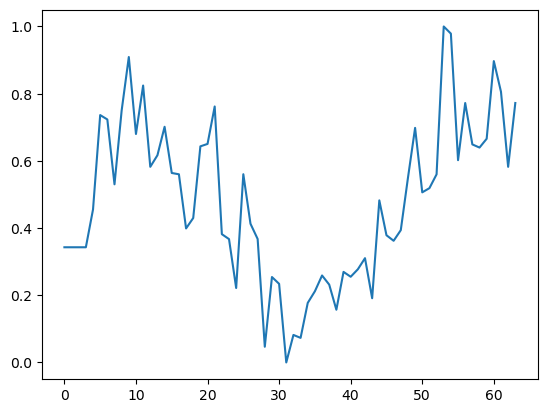

In [21]:
# Examine one of the non-transient light curves
plt.plot(list(range(64)),reduced_f_seq_array[1])
plt.show()

In [22]:
# Obtain the balanced sequences, targets and source information
final_seq_array = np.concatenate((reduced_f_seq_array, t_seq_array), axis=0)
final_src_array = np.concatenate((reduced_f_src_array, t_src_array), axis=0)
final_targets = np.array([0]*reduced_f_seq_array.shape[0]+[1]*t_seq_array.shape[0])

In [23]:
# Shuffle the indices of the balanced dataframe 
final_idx = np.array(range(final_seq_array.shape[0]))
final_idx = final_idx[prng.choice(final_idx.shape[0], len(final_idx), replace=False)]

In [24]:
# Use the shuffled indices to shuffle the dataframe
final_seq_array = final_seq_array[final_idx, :]
final_src_array = final_src_array[final_idx]
final_targets = final_targets[final_idx]

In [25]:
unique, counts = np.unique(final_targets, return_counts = True)

# Split The Data Into Training and Test Sets

In [26]:
def train_test_split(sequences, targets, train_prop = 0.7):
    """
    Splits the sequences and targets into training
    and testing data according to a particular proportion.

    Parameters
    ----------
    sequences : numpy array
        The lightcurves that are going to be split.

    targets : numpy array
        The labels that are going to be split.

    train_prop : float, default 0.7
        The proportion of the light curves and labels in
        the training set.

    Returns
    -------
    train_sequences : numpy array
        The light curves in the training set.

    test_sequences : numpy array
        The light curves in the test set.

    train_targets : numpy array
        The labels in the training set.

    test_targets : numpy array
        The labels in the test set.
    """
    # Obtain the number of training samples
    n_train = round(sequences.shape[0] * train_prop)

    # Obtaining train and test sequences
    train_sequences = sequences[:n_train+1,:]
    test_sequences = sequences[n_train+1:,:]

    # Obtaining train and test targets
    train_targets = targets[:n_train+1]
    test_targets = targets[n_train+1:]

    return train_sequences, test_sequences, train_targets, test_targets

In [27]:
# Separate sequences and labels into training and testing data
train, test, train_targets, test_targets = train_test_split(final_seq_array, final_targets, train_prop = 0.7)

In [28]:
train, val, train_targets, val_targets = train_test_split(train, train_targets, train_prop = 0.7)

In [29]:
train.shape

(247, 64)

In [30]:
test.shape

(150, 64)

In [31]:
unique, counts = np.unique(test_targets, return_counts = True)

# Implementing The LSTM Model

In [32]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(256, input_shape=(train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

In [33]:
# Use the Adam optimiser, track the validation accuracy and compile the model
adam = Adam(learning_rate=0.0001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(train, train_targets, epochs=100, batch_size=16, callbacks=[chk], validation_data=(val, val_targets))

Epoch 1/100
16/16 [==============================] - 5s 42ms/step - loss: 0.6939 - accuracy: 0.4737 - val_loss: 0.6927 - val_accuracy: 0.5143
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.6926 - accuracy: 0.5101 - val_loss: 0.6921 - val_accuracy: 0.5143
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.6918 - accuracy: 0.5101 - val_loss: 0.6918 - val_accuracy: 0.5143
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.6913 - accuracy: 0.5142 - val_loss: 0.6916 - val_accuracy: 0.5143
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.6910 - accuracy: 0.5142 - val_loss: 0.6914 - val_accuracy: 0.5048
Epoch 6/100
16/16 [==============================] - 0s 14ms/step - loss: 0.6906 - accuracy: 0.5142 - val_loss: 0.6912 - val_accuracy: 0.4952
Epoch 7/100
16/16 [==============================] - 0s 13ms/step - loss: 0.6905 - accuracy: 0.5142 - val_loss: 0.6910 - val_accuracy: 0.5048
Epoch 

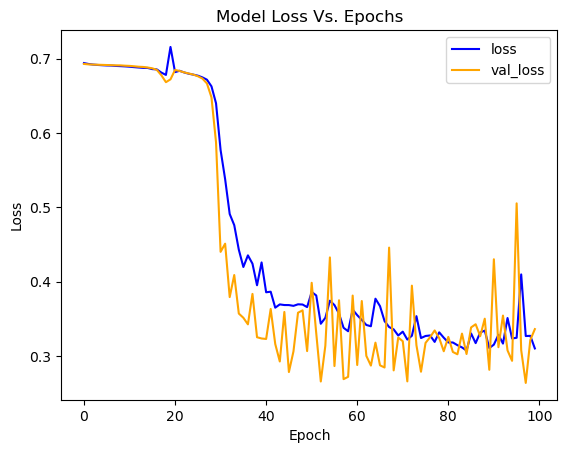

In [34]:
plt.plot(history.history['loss'],'b-')
plt.plot(history.history['val_loss'],'orange')
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Vs. Epochs')
plt.show()

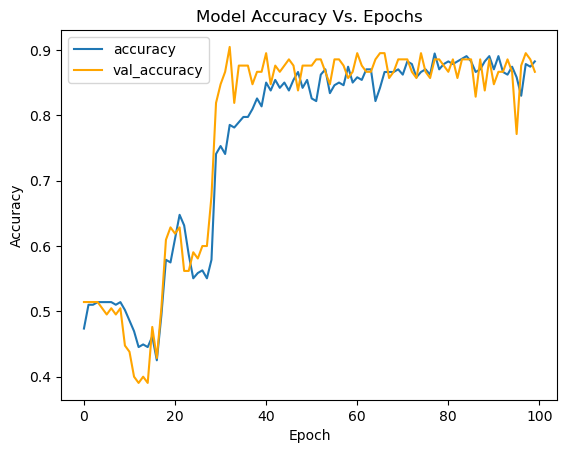

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'],'orange')
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Vs. Epochs')
plt.show()

Classifying the light curves time series data provides accuracies consistently in the high 80% range and losses approximately as low as 0.3. This is a significant improvement over the usage of convolutional neural networks on particular image slices. It may be worth investigating other time series classification methods such as ROCKET to determine if better metrics may be obtained.